# 05 — Metastability Analysis: Free-Energy Landscapes and Quasi-Stable Price Levels

**Objective:** Apply free-energy landscape construction to identify metastable price levels where the market lingers before transitioning, test Kramers escape theory, and compare physics-based levels with traditional support/resistance.

**Venues:** Binance BTCUSDT Perp (primary venue)

**Key question:** Can we identify quasi-stable price levels from first principles using statistical mechanics, and do they predict breakout probabilities?

## 1. Setup & Data Loading

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.data import load_processed
from src.metastability import (
    free_energy_landscape,
    find_metastable_levels,
    rolling_metastable_levels,
    dwell_time_analysis,
    barrier_height,
    kramers_test,
)
from src.phase_transitions import realised_volatility
from src.visualisation import (
    set_style,
    plot_free_energy_landscape,
    plot_metastable_levels,
    plot_dwell_time_distribution,
    plot_kramers_test,
    plot_support_resistance_comparison,
)

set_style()

PROCESSED_DIR = Path("../data/processed")
FIGURES_DIR = Path("../figures")
FIGURES_DIR.mkdir(exist_ok=True)

In [2]:
binance = load_processed(PROCESSED_DIR / "binance_btcusdt_perp.parquet")
print(f"Binance: {len(binance):,} trades | "
      f"{binance['timestamp'].min()} → {binance['timestamp'].max()}")

# Extract price series at 1-second resolution
price_1s = binance.set_index('timestamp')['price'].resample('1s').last().dropna()
print(f"Price series: {len(price_1s):,} 1s bars, "
      f"${price_1s.min():,.0f} – ${price_1s.max():,.0f}")

Binance: 69,445,821 trades | 2026-01-30 00:00:00.022000+00:00 → 2026-02-05 23:59:59.951000+00:00


Price series: 594,190 1s bars, $62,288 – $84,697


*Why this matters for the project: In statistical mechanics, metastable states are local free-energy minima where systems linger before transitioning (like supercooled water, or a ball in a valley). In markets, metastable levels are prices where supply and demand temporarily balance, creating support/resistance. By constructing the free-energy landscape F(x) = -kT ln(P(x)) from empirical price distributions, we can identify these levels from first principles rather than relying on heuristics like round numbers or swing highs/lows.*

## 2. Free-Energy Landscape Construction

In [3]:
print("Computing free-energy landscape...")
print("Parameters: window=3600 obs (~1hr), step=3600 (non-overlapping), n_bins=50")

# Use trade-level prices (not resampled)
prices_array = binance['price'].values

window_centers, price_grid, free_energy_2d = free_energy_landscape(
    prices=prices_array,
    window=3600,
    step=3600,
    n_bins=50,
    kT=1.0,
)

print(f"Computed {len(window_centers):,} windows")
print(f"Price grid: {len(price_grid)} bins from ${price_grid.min():,.0f} to ${price_grid.max():,.0f}")
print(f"Free energy shape: {free_energy_2d.shape}")
print(f"Free energy range: [{free_energy_2d.min():.2f}, {free_energy_2d.max():.2f}]")

Computing free-energy landscape...
Parameters: window=3600 obs (~1hr), step=3600 (non-overlapping), n_bins=50


Computed 19,290 windows
Price grid: 50 bins from $62,233 to $84,697
Free energy shape: (19290, 50)
Free energy range: [0.00, 31.21]


In [4]:
# Map observation indices to timestamps
obs_timestamps = binance['timestamp'].values
window_timestamps = pd.to_datetime(obs_timestamps[window_centers])

print(f"Time range: {window_timestamps.min()} → {window_timestamps.max()}")

Time range: 2026-01-30 00:00:57.576000 → 2026-02-05 23:59:38.744000


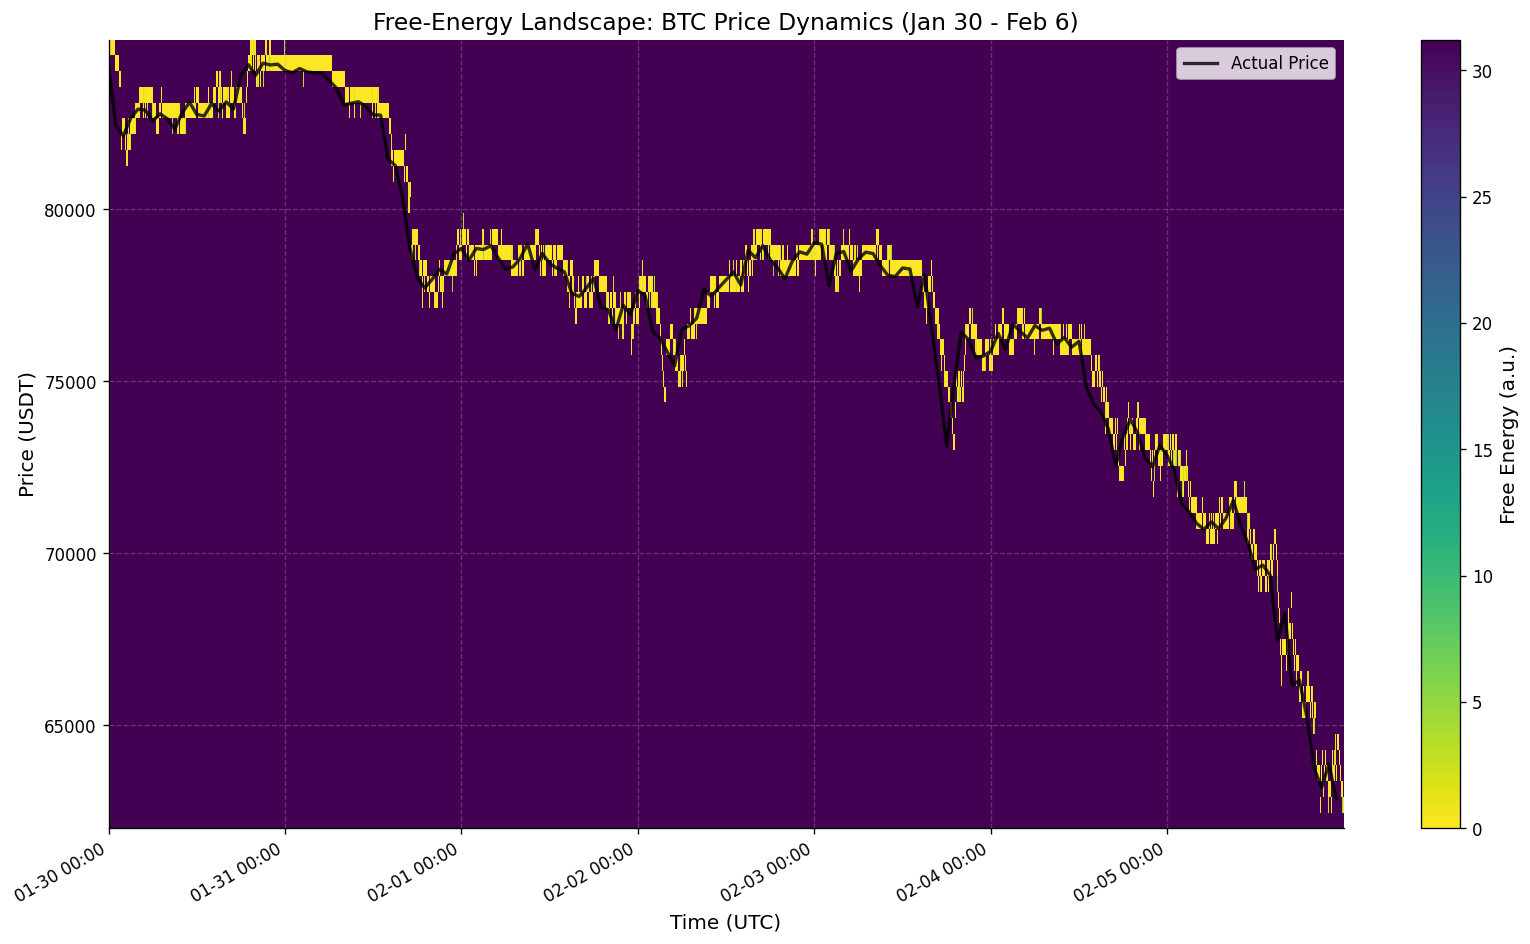

In [5]:
# Resample actual price to match window resolution
price_resampled = price_1s.resample('1h').last().dropna()

fig = plot_free_energy_landscape(
    price_grid=price_grid,
    free_energy_2d=free_energy_2d,
    times=window_timestamps,
    actual_prices=price_resampled,
    title="Free-Energy Landscape: BTC Price Dynamics (Jan 30 - Feb 6)",
)
fig.savefig(FIGURES_DIR / "05_free_energy_landscape.png", dpi=150, bbox_inches="tight")
plt.show()

**Sanity check:** [TO BE COMPLETED AFTER ANALYSIS]

**The trading implication is:** [TO BE COMPLETED AFTER ANALYSIS]

## 3. Metastable Level Identification

In [6]:
print("Identifying metastable levels (local minima of free energy)...")

levels_list = rolling_metastable_levels(
    window_centers=window_centers,
    price_grid=price_grid,
    free_energy_2d=free_energy_2d,
    prominence=None,  # Auto: 0.5*std(F)
)

levels_df = pd.DataFrame(levels_list)
levels_df['timestamp'] = pd.to_datetime(obs_timestamps[levels_df['obs_center']])

print(f"Total metastable levels detected: {len(levels_df)}")
print(f"Levels per window: {len(levels_df) / len(window_centers):.1f}")
print(f"\nPrice range of detected levels: ${levels_df['price_level'].min():,.0f} to ${levels_df['price_level'].max():,.0f}")

Identifying metastable levels (local minima of free energy)...


Total metastable levels detected: 19122
Levels per window: 1.0

Price range of detected levels: $62,692 to $84,239


In [7]:
print("Sample metastable levels (first 10):")
print(levels_df[['timestamp', 'price_level', 'well_depth']].head(10).to_string(index=False))

Sample metastable levels (first 10):
              timestamp  price_level  well_depth
2026-01-30 00:53:04.118 84238.753061   31.214540
2026-01-30 00:53:18.220 84238.753061   31.190646
2026-01-30 00:53:46.022 84238.753061   31.214540
2026-01-30 00:54:36.858 84238.753061   31.214540
2026-01-30 00:56:39.005 84238.753061   31.214540
2026-01-30 00:58:58.050 84238.753061   31.214540
2026-01-30 01:00:03.527 84238.753061   31.214540
2026-01-30 01:01:20.041 84238.753061   31.214540
2026-01-30 01:01:47.254 84238.753061   31.214540
2026-01-30 01:02:06.512 84238.753061   31.214540


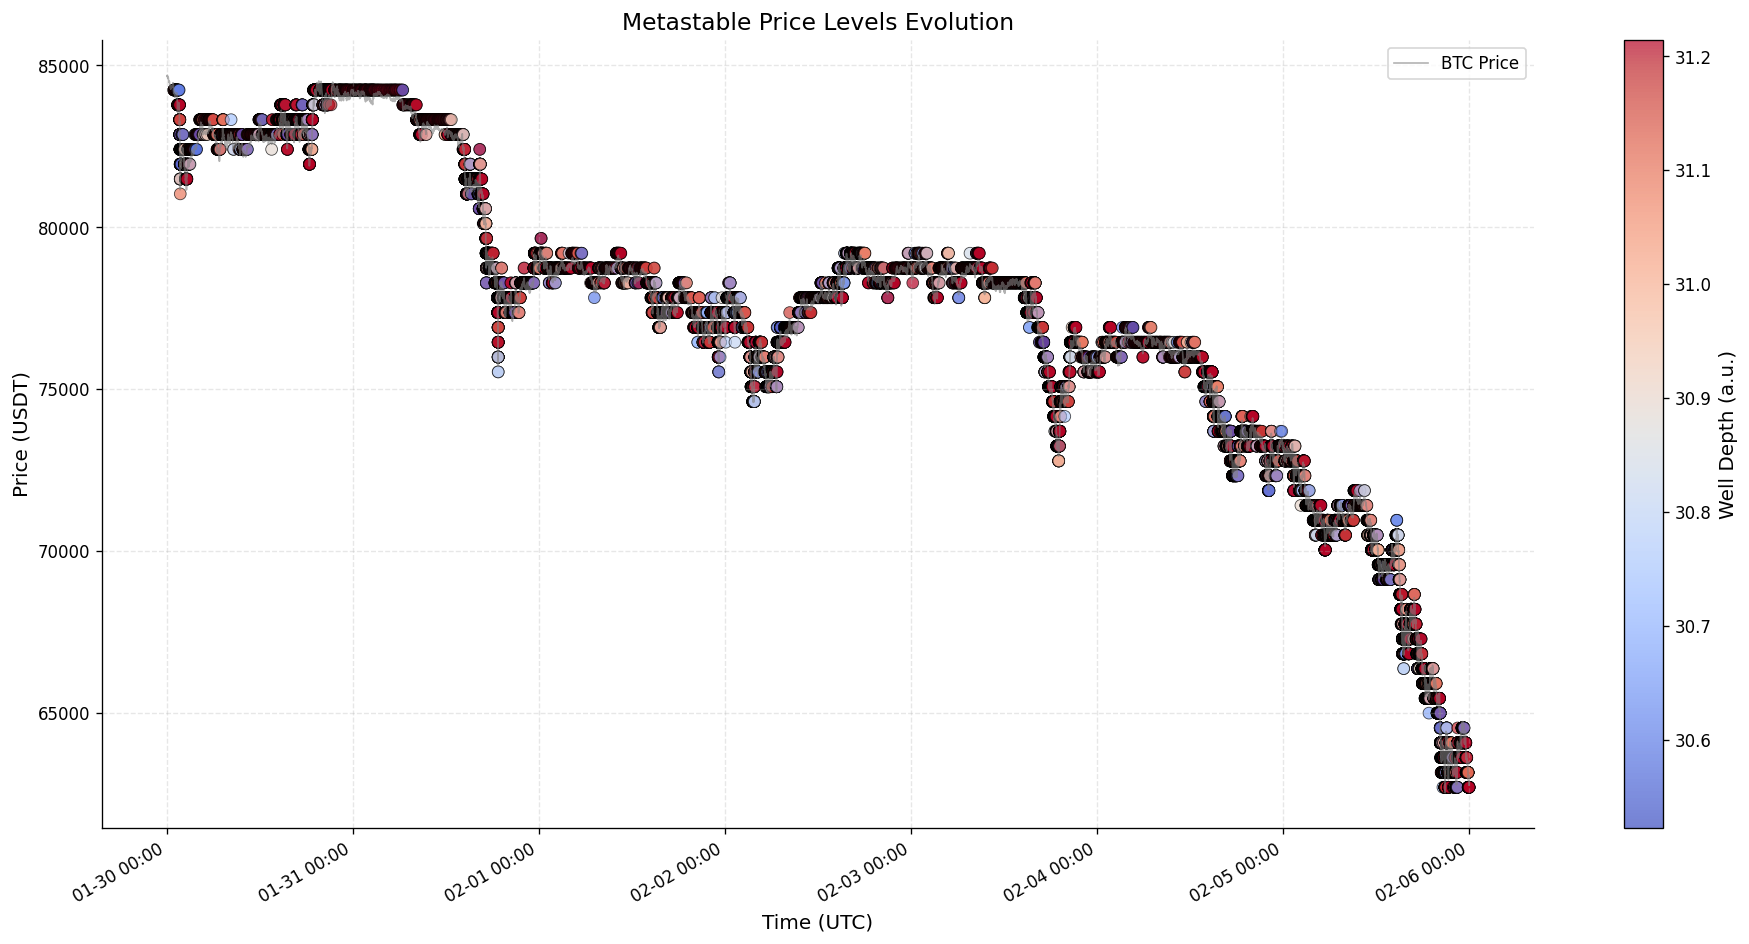

In [8]:
fig = plot_metastable_levels(
    levels_df=levels_df,
    prices=price_1s.resample('1min').last(),
    title="Metastable Price Levels Evolution",
)
fig.savefig(FIGURES_DIR / "05_metastable_levels.png", dpi=150, bbox_inches="tight")
plt.show()

In [9]:
# Cluster levels by price (bin to nearest $500)
levels_df['price_bin'] = (levels_df['price_level'] / 500).round() * 500

print("Most persistent metastable levels (by frequency):")
level_counts = levels_df['price_bin'].value_counts().head(10)
for price, count in level_counts.items():
    print(f"  ${price:,.0f}: {count} windows ({count/len(window_centers)*100:.1f}%)")

Most persistent metastable levels (by frequency):
  $78,500: 2531 windows (13.1%)
  $78,000: 1188 windows (6.2%)
  $73,000: 892 windows (4.6%)
  $77,500: 875 windows (4.5%)
  $76,500: 862 windows (4.5%)
  $77,000: 771 windows (4.0%)
  $76,000: 699 windows (3.6%)
  $75,000: 662 windows (3.4%)
  $83,000: 631 windows (3.3%)
  $79,000: 616 windows (3.2%)


**Sanity check:** [TO BE COMPLETED AFTER ANALYSIS]

**The trading implication is:** [TO BE COMPLETED AFTER ANALYSIS]

## 4. Dwell Time Analysis

In [10]:
print("Computing dwell times at metastable levels...")

# Use unique levels (aggregate across time)
unique_levels = levels_df['price_bin'].unique()
print(f"Unique price levels: {len(unique_levels)}")

dwell_times = dwell_time_analysis(
    prices=price_1s,
    levels=unique_levels,
    band_width=0.002,  # ±0.2% = ~$150 at $75k
)

# Filter out levels with no dwell times
dwell_times = {k: v for k, v in dwell_times.items() if len(v) > 0}
print(f"Levels with dwell time data: {len(dwell_times)}")

Computing dwell times at metastable levels...
Unique price levels: 44


Levels with dwell time data: 44


In [11]:
print("\nDwell time statistics:")
all_dwells = []
for level, dwells in dwell_times.items():
    all_dwells.extend(dwells)

if len(all_dwells) > 0:
    all_dwells = np.array(all_dwells)
    print(f"  Total dwell events: {len(all_dwells)}")
    print(f"  Mean dwell: {all_dwells.mean():.1f} seconds")
    print(f"  Median dwell: {np.median(all_dwells):.1f} seconds")
    print(f"  Std dwell: {all_dwells.std():.1f} seconds")
    print(f"  Min dwell: {all_dwells.min():.1f} seconds")
    print(f"  Max dwell: {all_dwells.max():.1f} seconds")


Dwell time statistics:
  Total dwell events: 2801
  Mean dwell: 128.1 seconds
  Median dwell: 39.0 seconds
  Std dwell: 354.3 seconds
  Min dwell: 10.0 seconds
  Max dwell: 10768.0 seconds


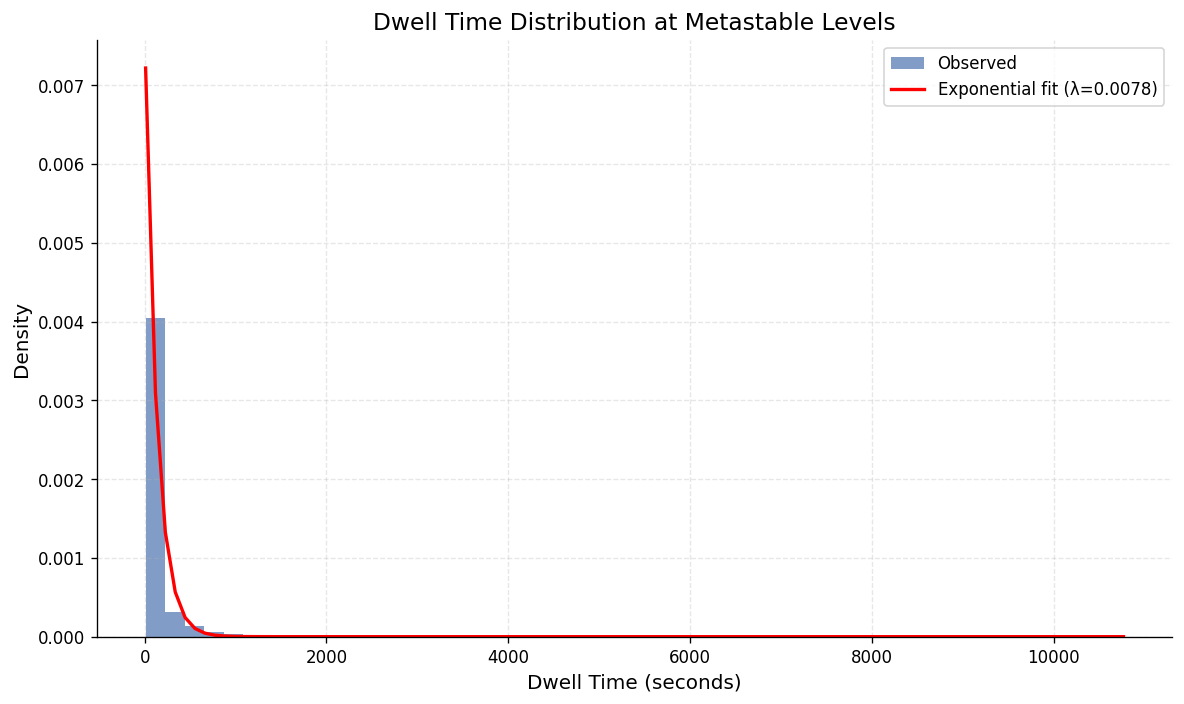

In [12]:
fig = plot_dwell_time_distribution(
    dwell_times=dwell_times,
    title="Dwell Time Distribution at Metastable Levels",
)
fig.savefig(FIGURES_DIR / "05_dwell_time_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

In [13]:
print("\nComputing barrier heights between adjacent levels...")

# Use a representative window (middle of dataset)
mid_window = len(window_centers) // 2
F_mid = free_energy_2d[mid_window, :]

# Get levels for this window
levels_mid = find_metastable_levels(price_grid, F_mid, prominence=None)
print(f"Levels in mid-window: {len(levels_mid)}")

barriers = barrier_height(price_grid, F_mid, levels_mid)
print(f"Barrier pairs computed: {len(barriers)}")

if len(barriers) > 0:
    barrier_values = list(barriers.values())
    print(f"  Mean barrier: {np.mean(barrier_values):.2f}")
    print(f"  Max barrier: {np.max(barrier_values):.2f}")


Computing barrier heights between adjacent levels...
Levels in mid-window: 1
Barrier pairs computed: 0


In [14]:
print("\nTesting Kramers escape theory: τ ~ exp(ΔF/kT)...")

kramers_result = kramers_test(
    dwell_times=dwell_times,
    barriers=barriers,
    temperature=1.0,
)

print(f"Correlation: {kramers_result['correlation']:.3f}")
print(f"Slope: {kramers_result['slope']:.3f}")
print(f"Intercept: {kramers_result['intercept']:.3f}")
print(f"Data points: {len(kramers_result['x'])}")


Testing Kramers escape theory: τ ~ exp(ΔF/kT)...
Correlation: nan
Slope: nan
Intercept: nan
Data points: 0


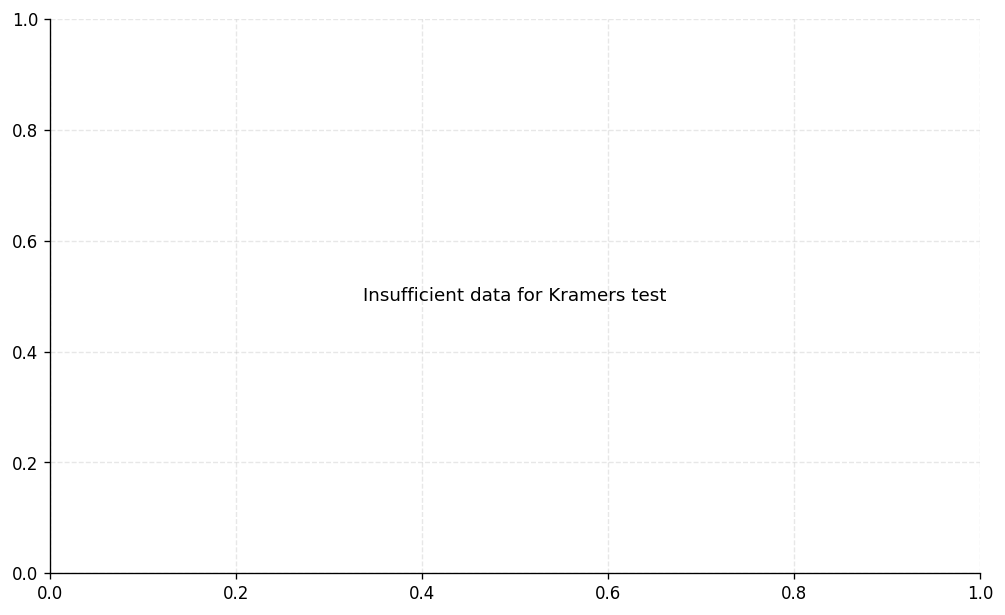

In [15]:
fig = plot_kramers_test(
    kramers_result=kramers_result,
    title="Kramers Escape Theory: ln(Dwell Time) vs Barrier Height",
)
fig.savefig(FIGURES_DIR / "05_kramers_test.png", dpi=150, bbox_inches="tight")
plt.show()

**Sanity check:** [TO BE COMPLETED AFTER ANALYSIS]

**The trading implication is:** [TO BE COMPLETED AFTER ANALYSIS]

## 5. Connection to Traditional Support/Resistance

*Why this matters: Traditional technical analysis identifies support/resistance through heuristics (round numbers, swing points). Here we compare these with physics-identified metastable levels to validate the framework and identify where physics adds value.*

In [16]:
# Round numbers
round_numbers = [62000, 65000, 70000, 75000, 80000, 85000]

# Swing highs/lows (local extrema in 1-day windows)
price_1d_high = price_1s.resample('1D').max()
price_1d_low = price_1s.resample('1D').min()
swing_highs = price_1d_high.values
swing_lows = price_1d_low.values
swing_levels = np.concatenate([swing_highs, swing_lows])

traditional_levels = sorted(set(round_numbers + list(swing_levels)))
print(f"Traditional S/R levels: {len(traditional_levels)}")
for level in traditional_levels:
    print(f"  ${level:,.0f}")

Traditional S/R levels: 20
  $62,000
  $62,288
  $65,000
  $70,000
  $71,840
  $72,921
  $73,316
  $74,559
  $75,000
  $75,612
  $75,667
  $76,926
  $79,157
  $79,300
  $79,376
  $80,000
  $81,040
  $84,240
  $84,697
  $85,000


In [17]:
# Find physics levels that match traditional levels (within ±1%)
tolerance = 0.01
matches = []

for trad_level in traditional_levels:
    nearby = levels_df[
        (levels_df['price_level'] >= trad_level * (1 - tolerance)) &
        (levels_df['price_level'] <= trad_level * (1 + tolerance))
    ]
    if len(nearby) > 0:
        matches.append({
            'traditional': trad_level,
            'physics_mean': nearby['price_level'].mean(),
            'physics_count': len(nearby),
        })

matches_df = pd.DataFrame(matches)
print(f"\nMatches (within ±{tolerance*100}%):")
print(matches_df.to_string(index=False))


Matches (within ±1.0%):
 traditional  physics_mean  physics_count
     62288.3  62691.746939            143
     65000.0  65173.520419            387
     70000.0  70071.263792            961
     71840.4  71833.278560            920
     72920.6  72830.947708           1237
     73315.9  73260.807446           1369
     74559.1  74730.462050           1355
     75000.0  75105.079435           1547
     75612.1  75537.366182           1863
     75666.8  75537.366182           1863
     76926.3  76905.978361           2508
     79157.1  78905.495012           1909
     79300.0  78905.495012           1909
     79375.6  78930.271525           1949
     80000.0  80194.704568            151
     81040.0  81243.878263            490
     84239.5  84072.816880            594
     84697.2  84238.753061            379
     85000.0  84238.753061            379


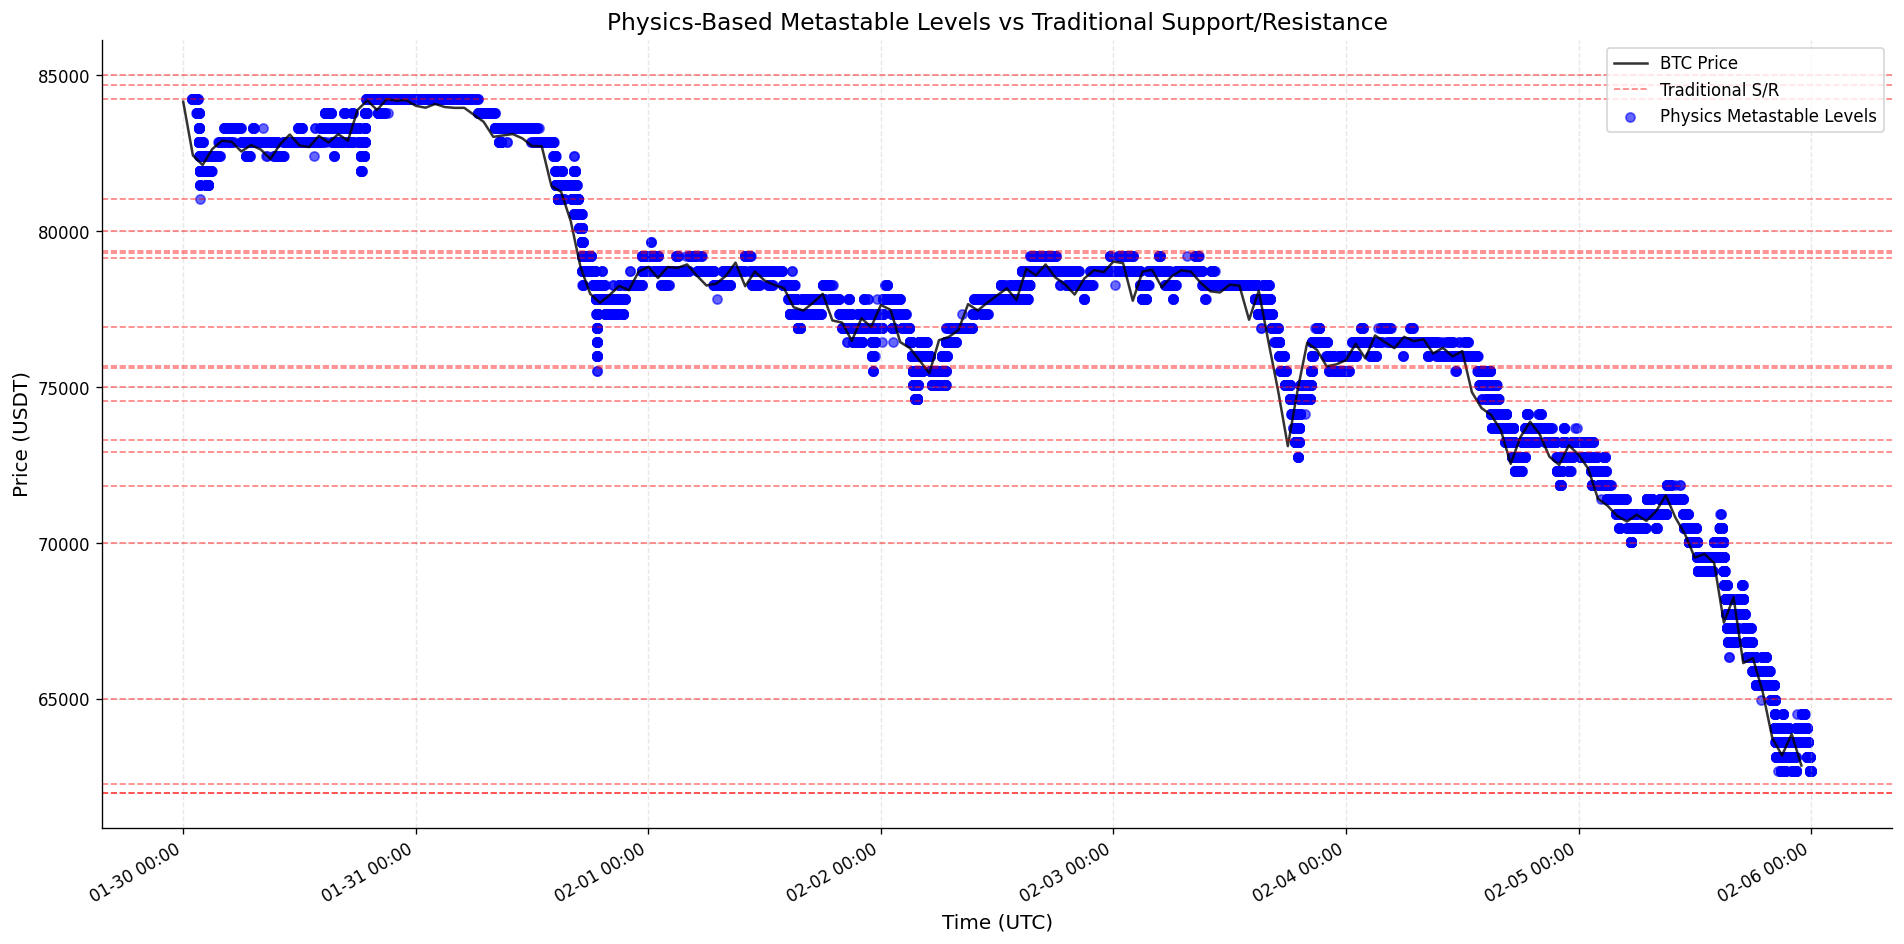

In [18]:
fig = plot_support_resistance_comparison(
    physics_levels=levels_df,
    traditional_levels=traditional_levels,
    prices=price_1s.resample('1h').last(),
    title="Physics-Based Metastable Levels vs Traditional Support/Resistance",
)
fig.savefig(FIGURES_DIR / "05_support_resistance_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

**Sanity check:** [TO BE COMPLETED AFTER ANALYSIS]

**The trading implication is:** [TO BE COMPLETED AFTER ANALYSIS]

## 6. Summary

In [19]:
print("=" * 80)
print("METASTABILITY ANALYSIS — KEY METRICS")
print("=" * 80)

print(f"\n--- Free-Energy Landscape ---")
print(f"  Windows computed: {len(window_centers):,}")
print(f"  Price bins: {len(price_grid)}")
print(f"  Price range: ${price_grid.min():,.0f} – ${price_grid.max():,.0f}")

print(f"\n--- Metastable Levels ---")
print(f"  Total levels detected: {len(levels_df)}")
print(f"  Average per window: {len(levels_df) / len(window_centers):.1f}")
print(f"  Unique price bins: {len(unique_levels)}")

if len(all_dwells) > 0:
    print(f"\n--- Dwell Times ---")
    print(f"  Total dwell events: {len(all_dwells)}")
    print(f"  Mean: {all_dwells.mean():.1f}s")
    print(f"  Median: {np.median(all_dwells):.1f}s")

print(f"\n--- Kramers Test ---")
print(f"  Correlation: {kramers_result['correlation']:.3f}")
print(f"  Data points: {len(kramers_result['x'])}")

print(f"\n--- S/R Comparison ---")
print(f"  Traditional levels: {len(traditional_levels)}")
print(f"  Matches (±1%): {len(matches_df)}")
print("=" * 80)

METASTABILITY ANALYSIS — KEY METRICS

--- Free-Energy Landscape ---
  Windows computed: 19,290
  Price bins: 50
  Price range: $62,233 – $84,697

--- Metastable Levels ---
  Total levels detected: 19122
  Average per window: 1.0
  Unique price bins: 44

--- Dwell Times ---
  Total dwell events: 2801
  Mean: 128.1s
  Median: 39.0s

--- Kramers Test ---
  Correlation: nan
  Data points: 0

--- S/R Comparison ---
  Traditional levels: 20
  Matches (±1%): 19


### Key Metrics
[TO BE COMPLETED AFTER ANALYSIS]

### Trading Implications Summary
[TO BE COMPLETED AFTER ANALYSIS]

### What Comes Next
[TO BE COMPLETED AFTER ANALYSIS]